# <div align = center> Projektseminar Deep Learning </div> #
## <div align = center> Deep Reinforcement Learning with Deep Q-Learning </div> ##
<div align = center> A group work from Simon Lausch, Jan Felix Fuchs & Paul Jansen </div> <br>
  
<div align = center> The following notebook contains the code we produced and the information we collected during the Projektseminar. <br>
Since we split our group after the mid-term presentations, our notebooks will differ from each other, especially in the second half. </div>

### 1. Installing and importing all necessary dependencies ###

In order to set up the game we wanted our agent to learn, we had to download and install the following modules via Anaconda.

In [1]:
#pip install gym[atari]
#pip install ale_py
#pip install autorom[accept-rom-license]
#pip install torch
#conda install pytorch-cuda = 11.6

import gym

### 2. Our environment ###

#### 2.1 Game principal ####

The game Freeway is similar to well-known games like Frogger or Crossy Road. Here, the player tries to manoeuvre a character, or more precisely a chicken, across a busy road without being run over by a car. In rendered mode, the game is limited to a length of 2 minutes and 30 seconds. It is therefore possible for the player to cross the road several times. If the chicken is hit by a car, it is reset to the beginning. The number and speed of the cars depends on the set difficulty.

#### 2.2 Creating our environment ####

By using the function gym.make() we create our environment. We pass the following parameters to the function: 
| Parameter | Value | Explanation |
| :--- | :----: | :--- |
| name | "ALE/Freeway-v5" | This is the name of our game. We are using the newest version v5. ALE (Arcade Learning Environment) is a framework used to develop AI agents for Atari games. |
| difficulty | 1 | The game provides two different difficulties. By setting the difficulty to 1, the chicken is moved back to the start after each collision. Using difficulty 0, it is only thrown back. |
| mode | 3 | The game provides eight different modes. As the value increases, so does the number and the speed of the cars. |
| obs_type | "rgb" | This argument determines what observations are returned by the environment. We can choose from rgb, greyscale and ram. |
| frameskip | 1 | This argument influences frame skipping (for more information read the paragraph stochasticity) |
| repeat_action_probability | 0 | This argument sets the probability for sticky actions (for more information read the paragraph stochasticity) |
| render_mode | "human" | By setting the render mode to "human" the game will be displayed while its running. During the training of the agent, we are not going to display the game. |

In [7]:
#Example for the creation of an environment
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "rgb", frameskip = 1, repeat_action_probability = 0, render_mode = "human")

#### 2.3 Observation space ####

In [10]:
observation_space = env.observation_space
print("If we choose rgb as the observation space our environment returns the following observation: {}".format(observation_space))
print("Since {} is the shape of our observation space, we recieve a 210px * 160px rgb image.".format(observation_space.shape))
print("The image is stored as a three-dimensional array. The dimensions are 210, 160 and 3.")
print("If you want to get an example of an image try printing observation_space.sample().")
#print(observation_space.sample())
print("By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.")

If we choose rgb as the observation space our environment returns the following observation: Box(0, 255, (210, 160, 3), uint8)
Since (210, 160, 3) is the shape of our observation space, we recieve a 210px * 160px rgb image.
The image is stored as a three-dimensional array. The dimensions are 210, 160 and 3.
If you want to get an example of an image try printing observation_space.sample().
By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.


#### 2.4 Action space ####

In [11]:
action_space = env.action_space
print("Number of different possible actions we can choose from: {}".format(action_space))
print("Possible actions with corresponding values:")
print(env.unwrapped.get_action_meanings())
print("[0, 1, 2]")
print("(NOOP stands for no operation which means that the chicken does not move.)")

Number of different possible actions we can choose from: Discrete(3)
Possible actions with corresponding values:
['NOOP', 'UP', 'DOWN']
[0, 1, 2]
(NOOP stands for no operation which means that the chicken does not move.)


#### 2.5 Rewards ####

Without any changes on the environment, there is only one reward. If the chickens crosses the road it recieves a reward with the value one. Except this case, there are no other rewards, neither for colliding with a car, nor for going backwards. In the following sections we will write our own reward function in order to achieve a better learning behaviour of our agent.

#### 2.5 Stochasticity ####

Since Atari games are deterministic, there is a possibility that the agent just memorizes an optimal sequence of actions instead of using the observations and the reward from the environment. Due to this fact ALE uses so called sticky actions. This ensures that with a low probability the previous action is repeated. Therefore, the action chosen by the agent is not executed. By specifing the repeat_action_probality parameter during the creation of the environment, we can influence the probality of these sticky actions.  
Additionally, Gym implements frame skipping which means that in each step the action is repeated for a random number of frames. By specifing the frameskip parameter during the creation of the environment, we can influece this number of frames. Specifically, the value indicates how often an action is repeated per step. By setting this value to one, we prevent frame skipping.

### 3. First Version: Random choices ###

In this first version the agent chooses a random action from the action space (up, down or no operation). We have chosen the following probabilities:
| Action | Number | Probability |
| :--- | :----: | :---: |
| Standing still | 0 | 3% |
| Moving forwards | 1 | 90% | 
| Moving backwards | 2 | 7% |

In [ ]:
import gym
import random

#Creating the environment
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 0, obs_type = "rgb", frameskip = 1, repeat_action_probability = 0, render_mode = "human")

#Reseting the environment
env.reset()
terminated = False

while(not terminated):
    #Choosing a random number between 0 and 1
    rand_number = random.random()

    if(rand_number < 0.9):
        #Moving forwards
        random_action = 1
    elif(rand_number < 0.97):
        #Moving backwards
        random_action = 2
    else:
        #Standing still
        random_action = 0

    #Recieving information
    observation, reward, terminated, truncated, info = env.step(random_action)
    
    #Render the environment
    env.render()
env.close()

### 4. Changing the reward function ###

Since the game comes with a basic reward function, we are modifing the rewards.

In [6]:
import numpy as np

class ClipReward(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM (observation space)
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reset and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175): 
            #Chicken reaches the goal
            reward = 10000
            self.target_runs += 1
        elif(current_pos > self.pre_pos): 
            #Chicken moves forward
            reward = 1
        elif(self.pre_pos < 175): 
            #Chicken did not reach the goal yet
            if(current_pos == 6 and self.pre_pos > 6 and (not cooldown == 0)):
                #Chicken collides with a car (reset)
                #By checking the cooldown value we are making sure that the we detect a "false" collision
                #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
                reward = -1000
            elif(current_pos < self.pre_pos): 
                #Chicken moves backwards
                reward = -1
        else:
            #Chicken does not move
            reward = 0
        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

### 5. The first neural network ###

# TODO #

Our first neural network is a deep q-network which uses the RAM as the observation space. 



REFERENCES

#### 5.1 Importing all necessary modules ####

In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym

#### 5.2 The DeepQNetwork class ####

In [3]:
class DeepQNetwork(nn.Module):
    #Method to initialize the dqn
    def __init__(self, lr, dims_input, dims_fc1, dims_fc2, n_actions):
        #Inheritance: calling the constructor of the super class
        super(DeepQNetwork, self).__init__()
        #Saving the given parameters
        self.dims_input = dims_input                                #Dimensions of the input
        self.dims_fc1 = dims_fc1                                    #Dimensions of the first fully connected layer
        self.dims_fc2 = dims_fc2                                    #Dimensions of the second fully connected layer
        self.n_actions = n_actions                                  #number of possible actions

        #On each layer a linear transformation is applied
        self.fc1 = nn.Linear(*self.dims_input, self.dims_fc1)       #* unzips dims_input
        self.fc2 = nn.Linear(self.dims_fc1, self.dims_fc2)
        self.fc3 = nn.Linear(self.dims_fc2, self.n_actions)

        #Setting up the optimization function which is using the adam algorithm
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        
        #Setting up the Mean squared error loss function
        self.loss = nn.MSELoss()

        #Choosing a GPU if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    #Method to calculate actions
    def forward(self, state):
        #Applying the activiation function (relu)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        #Only applied to the first two layers, not the output
        actions = self.fc3(x)

        #Returing
        return actions

#### 5.3 The Agent class ####

In [4]:
class Agent():
    #Method to initialize the agent
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size = 1000000, eps_end = 0.01, eps_dec = 6.1875e-7):
        #Saving the given parameters
        self.runs = 0                                                  #Number of runs
        self.gamma = gamma                                             #Gamma (discount factor)
        self.epsilon = epsilon                                         #Epsilon
        self.eps_min = eps_end                                         #Lowest epsilon
        self.eps_dec = eps_dec                                         #Descent for epsilon
        self.lr = lr                                                   #Learning rate
        self.action_space = [i for i in range(n_actions)]              #Action space
        self.mem_size = max_mem_size                                   #Memory size
        self.batch_size = batch_size                                   #Batch size
        self.mem_counter = 0                                           #Counter for the memory
        
        #Initializing our dqn (using two fully conected layer with 256 inputs each)
        self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, dims_input = input_dims, dims_fc1 = 256, dims_fc2 = 256)

        #Initializing our memory (state, new state, action, reward & termination)
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype = np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.bool_)
    
    #Method to store a transition inside the memory
    def store_transition(self, state, action, reward, state_, done):
        #Determining the storage index
        index = self.mem_counter % self.mem_size
        
        #Storing the given state, new state, reward, action and termination information
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        #Increasing the memory counter by one
        self.mem_counter += 1
    
    #Method to choose one of the previously calculated actions 
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            #Exploitation
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            #Choosing the best action (argmax returns the index of the highest value)
            action = T.argmax(actions).item()
        else:
            #Exploration (choosing a random action)
            action = np.random.choice(self.action_space)

        #Returning the selected action
        return action

    #Method to let the agent learn
    def learn(self):
        if self.mem_counter < self.batch_size:
            #Since the batch is empty at the beginning, we are filling it before the agent starts to learn 
            return
        
        #Setting the gradients of the optimized tensors to zero (Otherwise these are cumulated by pytorch)
        self.Q_eval.optimizer.zero_grad()

        #Getting the maximum memory entry we can reach
        max_mem = min(self.mem_counter, self.mem_size)

        #Choosing a random memory entry (as many times as one batch is big)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        #Creating an array with the batch_size in order to slice the calculated values for the actions
        batch_index = np.arange(self.batch_size, dtype = np.int32)

        #Getting the states, new states, rewards, actions and termination information for the batch
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        #Calculating the estimate during the previous state and slicing them in order to get the estimate for the action the agent selected 
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        #Calculating the estimate for the next state (batch_size times) 
        q_next = self.Q_eval.forward(new_state_batch)
        #Setting values of terminal states to zero
        q_next[terminal_batch] = 0.0
        #Calculating the target values
        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]
        
        #Calculating the loss (mean squared error)
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        #Perfoming backpropagation
        loss.backward()
        #Updating (optimizing) the parameters 
        self.Q_eval.optimizer.step()

        #Decreasing the epsilon value
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

        #Increasing the number of runs
        self.runs += 1

    #Method to recieve a model
    def getModel(self):
        return self.Q_eval

    #Method to set a trained model
    def setModel(self, path):
        self.Q_eval = T.load(path)

### 6. Running the dqn ###

#### 6.1 Run: games = 400 , epsilon descent 1.5e-6, learning rate = 0.003, discount factor = 0.99 ####

C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_13688\3759288688.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation]).to(self.Q_eval.device)


0
episode  0 score -12720.00 epsilon 1.00
0
episode  1 score -13320.00 epsilon 0.99
0
episode  2 score -12470.00 epsilon 0.99
0
episode  3 score -12630.00 epsilon 0.99
0
episode  4 score -13110.00 epsilon 0.98
0
episode  5 score -14010.00 epsilon 0.98
0
episode  6 score -12560.00 epsilon 0.98
0
episode  7 score -11420.00 epsilon 0.98
0
episode  8 score -11140.00 epsilon 0.97
0
episode  9 score -10970.00 epsilon 0.97
0
episode  10 score -12230.00 epsilon 0.97
0
episode  11 score -10500.00 epsilon 0.96
0
episode  12 score -12650.00 epsilon 0.96
0
episode  13 score -10210.00 epsilon 0.96
0
episode  14 score -12640.00 epsilon 0.95
0
episode  15 score -12410.00 epsilon 0.95
0
episode  16 score -13360.00 epsilon 0.95
0
episode  17 score -10980.00 epsilon 0.94
0
episode  18 score -12220.00 epsilon 0.94
0
episode  19 score -12340.00 epsilon 0.94
0
episode  20 score -11490.00 epsilon 0.94
0
episode  21 score -11270.00 epsilon 0.93
0
episode  22 score -10650.00 epsilon 0.93
0
episode  23 score -

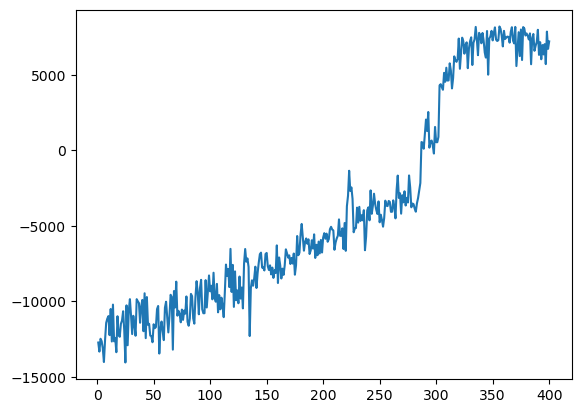

In [6]:
#Importing modules
import gym
import numpy as np
from matplotlib import pyplot as plt

#Creating the environment and the agent
env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), -100, 100)
agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size = 64, n_actions = 3, eps_end = 0.01, input_dims = [128], lr = 0.003)

#Creating lists for the score (cumulative reward) and the epsilon history
scores, eps_history = [], []
n_games = 400

for i in range(n_games):
    score = 0
    done = False
    
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the score
        score += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)
        
        #Getting the agent to learn
        agent.learn()
        
        #Updating the previous state
        observation = observation_
    
    #Appending the score and the epsilon history
    scores.append(score)
    eps_history.append(agent.epsilon)

    #Recieving the number of target runs during the last game
    print(ClipReward.get_TargetRuns(env))

    #Printing the most important information
    print('episode ', i, 'score %.2f' % score, 'epsilon %.2f' % agent.epsilon)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dadajdand2')

#Plotting:
x = [i + 1 for i in range(n_games)]
plt.plot(x, scores)
plt.show()

#### 6.2 Run: games = 1000 , epsilon descent 6.1875e-7, learning rate = 0.003, discount factor = 0.99 ####

C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_13796\2219341422.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation]).to(self.Q_eval.device)


Episode:  0 , Cumulative reward:  -52845.0 , Epsilon: 0.99877178 , Target runs:  0
Episode:  1 , Cumulative reward:  -56825.0 , Epsilon: 0.99750458 , Target runs:  0
Episode:  2 , Cumulative reward:  -54839.0 , Epsilon: 0.99623738 , Target runs:  0
Episode:  3 , Cumulative reward:  -47864.0 , Epsilon: 0.99497018 , Target runs:  0
Episode:  4 , Cumulative reward:  -53853.0 , Epsilon: 0.99370298 , Target runs:  0
Episode:  5 , Cumulative reward:  -55835.0 , Epsilon: 0.99243578 , Target runs:  0
Episode:  6 , Cumulative reward:  -51864.0 , Epsilon: 0.99116858 , Target runs:  0
Episode:  7 , Cumulative reward:  -51846.0 , Epsilon: 0.98990138 , Target runs:  0
Episode:  8 , Cumulative reward:  -53855.0 , Epsilon: 0.98863418 , Target runs:  0
Episode:  9 , Cumulative reward:  -53842.0 , Epsilon: 0.98736698 , Target runs:  0
Episode:  10 , Cumulative reward:  -47848.0 , Epsilon: 0.98609978 , Target runs:  0
Episode:  11 , Cumulative reward:  -60832.0 , Epsilon: 0.98483258 , Target runs:  0
Ep

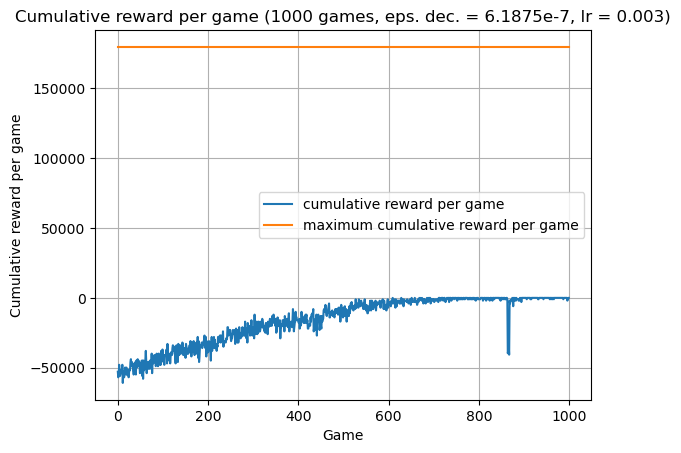

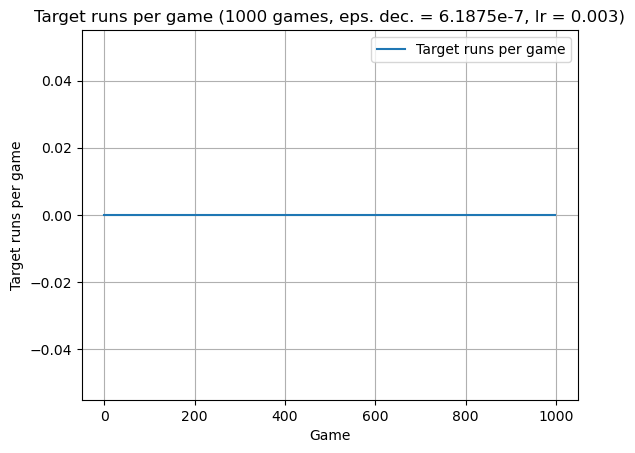

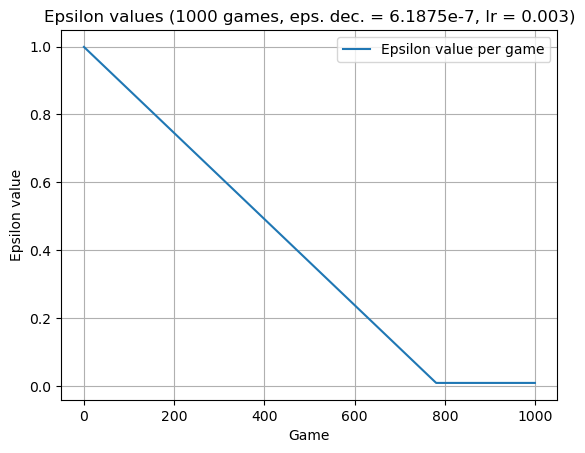

In [7]:
#Importing modules
import gym
import numpy as np
import matplotlib.pyplot as plt

#Creating the environment and the agent
env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), -1000, 10000)
agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size = 64, n_actions = 3, eps_end = 0.01, input_dims = [128], lr = 0.003)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []
n_games = 1000                                                      #Number of games
max_cum_reward = [(3000/170) * (1 * 170 + 10000)] * n_games         #Maximum cumulative reward

for i in range(n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]
    
    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))
        
        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_
    
    #Recieving the number of target runs during the last game
    target_runs = ClipReward.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward.reset_TargetRuns(env)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\model_1000games_10000maxreward_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\model_finished_1000games_10000maxreward.pth')

#Plotting:
x = np.arange(0, n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cummulative reward per game
plt.plot(x, max_cum_reward, label = "maximum cumulative reward per game")                   #Maximum cummulative reward per game
plt.title("Cumulative reward per game (1000 games, eps. dec. = 6.1875e-7, lr = 0.003)")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #amount of target runs
plt.title("Target runs per game (1000 games, eps. dec. = 6.1875e-7, lr = 0.003)")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #amount of target runs
plt.title("Epsilon values (1000 games, eps. dec. = 6.1875e-7, lr = 0.003)")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

#### 6.3 Letting the trained agent play the game ####

In [ ]:
#Importing modules
import gym

#Creating the environment, the agent and the model
env = ClipReward(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram", render_mode = "human"), -100, 100)
agent = Agent(gamma = 0.99, epsilon = 0.0, batch_size = 64, n_actions = 3, eps_end = 0.0, input_dims = [128], lr = 0.003)
Agent.setModel(agent, 'C:\\Users\Jan Felix\Desktop\dqn_model\dadajdand2')

n_games = 3

#Recieving the first state
observation = env.reset()[0]

while not done:
    #Choose an action (after conversion from int to float values)
    action = agent.choose_action(np.float32(observation))

    #Recieving the new state, reward and termination information (cutting off unnecessary information)
    observation_, reward, done = env.step(action)[:3]
        
    #Updating the previous state
    observation = observation_

    env.render()